In [1]:
import os
import gc
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
from Datasets import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# plot train and evaluation loss over iterations. option to specifiy first plotted iteration
def plot_train_eval_loss(train_loss_path, eval_loss_path, start_iteration = 0):
    train_loss_arr = np.load(train_loss_path) # array of noise pred loss values
    eval_loss_table = np.load(eval_loss_path) # table of iteration, noise pred loss, reconstruction loss

    train_x = np.arange(0, len(train_loss_arr))
    train_noise_pred_loss = train_loss_arr

    eval_x = eval_loss_table[:, 0].astype(int)
    eval_noise_pred_loss = eval_loss_table[:, 1]
    eval_reconstruction_loss = eval_loss_table[:, 2]

    if start_iteration > 0:
      mask_train = train_x >= start_iteration
      mask_eval = eval_x >= start_iteration

      train_x = train_x[mask_train]
      train_noise_pred_loss = train_noise_pred_loss[mask_train]

      eval_x = eval_x[mask_eval]
      eval_noise_pred_loss = eval_noise_pred_loss[mask_eval]
      eval_reconstruction_loss = eval_reconstruction_loss[mask_eval]
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_x, train_noise_pred_loss, label='Train Noise Pred Loss', linewidth=1)
    plt.plot(eval_x, eval_noise_pred_loss, label='Eval Noise Pred Loss', linewidth=1)
    plt.plot(eval_x, eval_reconstruction_loss, label='Eval Reconstruction Loss', linewidth=1)
    plt.xlabel('Train Iteration')
    plt.ylabel('Avg. Loss')
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.title('Train Iteration vs Avg. Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    x = torch.ones(1, device=DEVICE)
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    x = torch.ones(1, device=DEVICE)
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")

RGB_IMG_PATHS = [
  '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_img_drone_V1.npy'
]
SATELLITE_IMG_PATHS = [
  '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_naip/224naip_img_norm_satellite_V1.npy'
]

INTERVAL = 100 # number of reconstruction time intervals
NUM_ITR = 1001 # number of train iterations
BATCH_SIZE = 256
LR = 4e-4

Using Apple Metal Performance Shaders (MPS) device.


# Config

In [4]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=INTERVAL,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=BATCH_SIZE)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=NUM_ITR,     help="training iteration")
parser.add_argument("--lr",             type=float, default=LR,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=None,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

if opt.ckpt:
    ckpt_file = RESULT_DIR / opt.ckpt / "latest.pt"
    assert ckpt_file.exists()
    opt.load = ckpt_file
else:
    opt.load = None

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"



# Prepare Data

In [5]:
# Dataset creation from list of npy files

subdatasets = []

for hr_f, lr_f in zip(RGB_IMG_PATHS, SATELLITE_IMG_PATHS):
  hr_mem = np.load(hr_f, mmap_mode='r')
  lr_mem = np.load(lr_f, mmap_mode='r')
  subdatasets.append(
    Image2ImageDataset(lr_mem, hr_mem)
  )

full_dataset = ConcatDataset(subdatasets) # wrapper that routes indices to sub-datasets
full_length = len(full_dataset)
print(f"Combined dataset has length={full_length}")
n_train = int(0.9*full_length)
n_val = full_length - n_train

train, val = random_split(
    full_dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(1234)
) # returns 2 subset objects. each subset object holds list of indices into full

print(f"Train dataset length: {len(train)}. Evaluate dataset length:{len(val)}")

Combined dataset has length=45540
Train dataset length: 40986. Evaluate dataset length:4554


In [6]:
from i2sb.i2i_runner import Runner

# build runner
run = Runner(opt)
# print(run.net)

# check trainable parameters
for name, param in run.net.named_parameters():
    print(f"{name:40s}  requires_grad={param.requires_grad}")


/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Image2ImageDiffusion(
  (encoder): Sequential(
    (0): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [7]:
train_loss, eval_loss = run.train(opt, train, val)

train_inner_loop:   0%|          | 0/64 [00:00<?, ?it/s]/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 21.36it/s]


train_it 1/1001 | lr:4.00e-04 | noise_prediction_loss:+51117.4585
Saved weights and losses on iteration 0


eval_inner_loop: 100%|██████████| 64/64 [00:14<00:00,  4.49it/s]


EVALUATE: eval_it 1/1001 | noise_prediction_loss:+44633.1971 | reconstruction_loss:+4360.7231


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 29.04it/s]


train_it 2/1001 | lr:4.00e-04 | noise_prediction_loss:+45225.6749


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 29.46it/s]


train_it 3/1001 | lr:4.00e-04 | noise_prediction_loss:+52024.1097


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 28.36it/s]


train_it 4/1001 | lr:4.00e-04 | noise_prediction_loss:+47998.8765


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 27.29it/s]


train_it 5/1001 | lr:4.00e-04 | noise_prediction_loss:+51814.5488


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 26.09it/s]


train_it 6/1001 | lr:4.00e-04 | noise_prediction_loss:+52720.0169


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 29.13it/s]


train_it 7/1001 | lr:4.00e-04 | noise_prediction_loss:+51659.8039


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 29.02it/s]


train_it 8/1001 | lr:4.00e-04 | noise_prediction_loss:+51107.9348


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 29.02it/s]


train_it 9/1001 | lr:4.00e-04 | noise_prediction_loss:+51638.8693


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 28.04it/s]


train_it 10/1001 | lr:4.00e-04 | noise_prediction_loss:+54467.4825


train_inner_loop: 100%|██████████| 64/64 [00:02<00:00, 23.86it/s]


train_it 51/1001 | lr:4.00e-04 | noise_prediction_loss:+42945.5036


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 20.00it/s]


train_it 101/1001 | lr:4.00e-04 | noise_prediction_loss:+34058.0820


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 16.34it/s]


train_it 151/1001 | lr:4.00e-04 | noise_prediction_loss:+24551.5822


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 16.49it/s]


train_it 201/1001 | lr:4.00e-04 | noise_prediction_loss:+18500.6174


eval_inner_loop: 100%|██████████| 64/64 [00:23<00:00,  2.76it/s]


EVALUATE: eval_it 201/1001 | noise_prediction_loss:+23444.7158 | reconstruction_loss:+2195.5577


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 13.31it/s]


train_it 251/1001 | lr:4.00e-04 | noise_prediction_loss:+20147.7510


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 19.12it/s]


train_it 301/1001 | lr:4.00e-04 | noise_prediction_loss:+20407.7679


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 18.36it/s]


train_it 351/1001 | lr:4.00e-04 | noise_prediction_loss:+19827.2828


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 18.81it/s]


train_it 401/1001 | lr:4.00e-04 | noise_prediction_loss:+18919.0002


eval_inner_loop: 100%|██████████| 64/64 [00:20<00:00,  3.19it/s]


EVALUATE: eval_it 401/1001 | noise_prediction_loss:+22298.7625 | reconstruction_loss:+1919.1714


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 18.66it/s]


train_it 451/1001 | lr:4.00e-04 | noise_prediction_loss:+18398.2192


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 17.19it/s]


train_it 501/1001 | lr:4.00e-04 | noise_prediction_loss:+17948.6998


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 15.38it/s]


train_it 551/1001 | lr:4.00e-04 | noise_prediction_loss:+15970.1412


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 14.61it/s]


train_it 601/1001 | lr:4.00e-04 | noise_prediction_loss:+18130.1765


eval_inner_loop: 100%|██████████| 64/64 [00:22<00:00,  2.85it/s]


EVALUATE: eval_it 601/1001 | noise_prediction_loss:+13271.4480 | reconstruction_loss:+1434.8719


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 16.12it/s]


train_it 651/1001 | lr:4.00e-04 | noise_prediction_loss:+14947.5884


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 15.58it/s]


train_it 701/1001 | lr:4.00e-04 | noise_prediction_loss:+17960.0430


train_inner_loop: 100%|██████████| 64/64 [00:03<00:00, 17.91it/s]


train_it 751/1001 | lr:4.00e-04 | noise_prediction_loss:+16032.1141


train_inner_loop: 100%|██████████| 64/64 [00:05<00:00, 12.72it/s]


train_it 801/1001 | lr:4.00e-04 | noise_prediction_loss:+13574.9287


eval_inner_loop: 100%|██████████| 64/64 [00:28<00:00,  2.26it/s]


EVALUATE: eval_it 801/1001 | noise_prediction_loss:+13865.8777 | reconstruction_loss:+1382.5802


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 15.19it/s]


train_it 851/1001 | lr:4.00e-04 | noise_prediction_loss:+14435.6420


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 13.84it/s]


train_it 901/1001 | lr:4.00e-04 | noise_prediction_loss:+18551.0074


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 13.55it/s]


train_it 951/1001 | lr:4.00e-04 | noise_prediction_loss:+11929.1488


train_inner_loop: 100%|██████████| 64/64 [00:04<00:00, 13.87it/s]


train_it 1001/1001 | lr:3.96e-04 | noise_prediction_loss:+15270.5695
Saved weights and losses on iteration 1000


eval_inner_loop: 100%|██████████| 64/64 [00:28<00:00,  2.25it/s]

EVALUATE: eval_it 1001/1001 | noise_prediction_loss:+14917.5324 | reconstruction_loss:+1420.6456


In [8]:
# t_noise_pred_l = np.load('results/test/train_losses.npy')
# ti = np.arange(0, len(t_noise_pred_l))

# e = np.load('results/test/eval_losses.npy')
# ei = e[:, 0].astype(int)
# e_noise_pred_l = e[:, 1]
# e_reconstruction_l = e[:, 2]

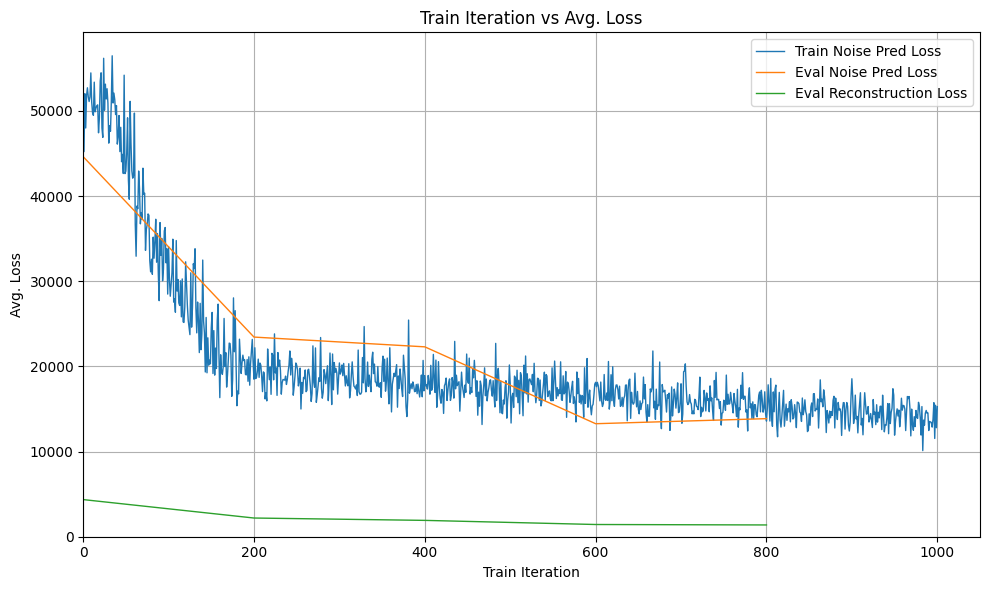

In [9]:
plot_train_eval_loss(train_loss_path='results/test/train_losses.npy', eval_loss_path='results/test/eval_losses.npy', start_iteration = 0)

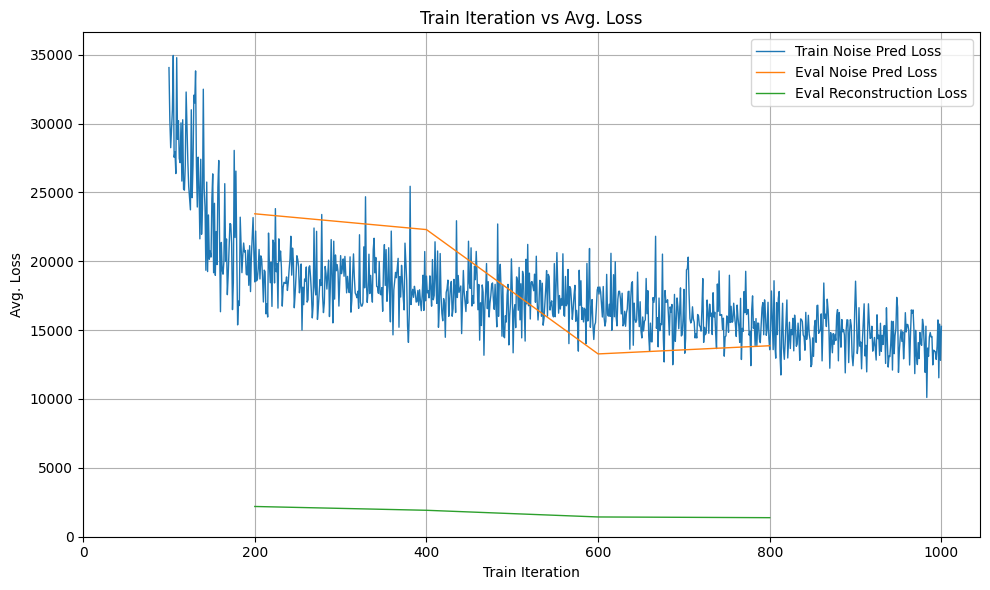

In [10]:
plot_train_eval_loss(train_loss_path='results/test/train_losses.npy', eval_loss_path='results/test/eval_losses.npy', start_iteration = 100)

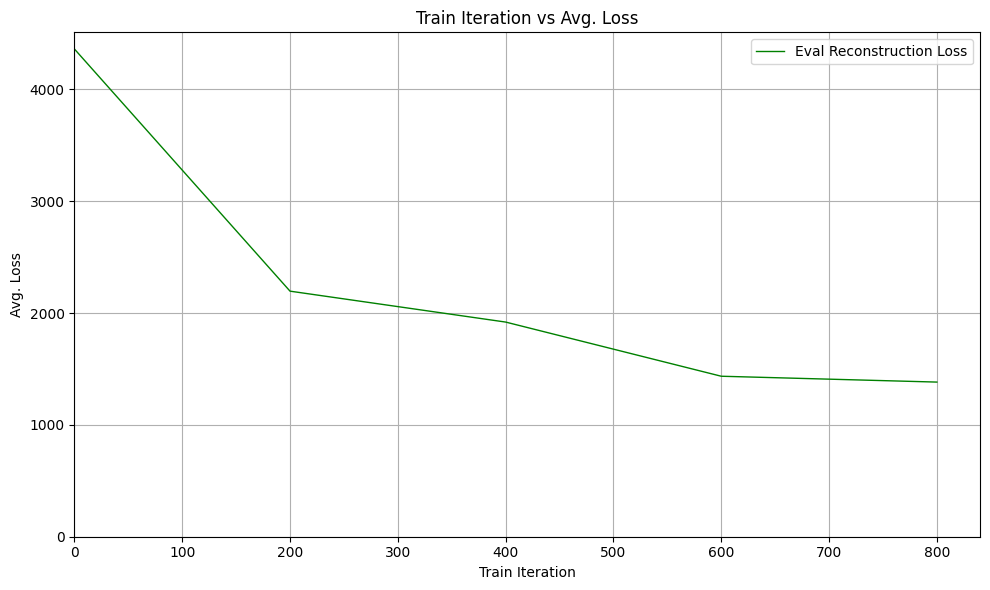

In [11]:
# plot train and evaluation loss over iterations. option to specifiy first plotted iteration
train_loss_arr = np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/train_losses.npy') # array of noise pred loss values
eval_loss_table = np.load('/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/eval_losses.npy') # table of iteration, noise pred loss, reconstruction loss

train_x = np.arange(0, len(train_loss_arr))
train_noise_pred_loss = train_loss_arr

eval_x = eval_loss_table[:, 0].astype(int)
eval_noise_pred_loss = eval_loss_table[:, 1]
eval_reconstruction_loss = eval_loss_table[:, 2]


plt.figure(figsize=(10, 6))
plt.plot(eval_x, eval_reconstruction_loss, label='Eval Reconstruction Loss', linewidth=1, color='g')
plt.xlabel('Train Iteration')
plt.ylabel('Avg. Loss')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title('Train Iteration vs Avg. Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()